In [1]:

import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf
import tensorflow as tf
  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

c:\Users\sneha sucharitha\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import zipfile

# Path to your zip file
zip_path = "dataset.zip"  # <-- Change this if your zip name is different
extract_to = "dataset"

# Unzipping process
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ Dataset unzipped successfully into:", extract_to)


✅ Dataset unzipped successfully into: dataset


In [3]:
dataset_dir = r"dataset/dataset"

image_size = (124, 124)
batch_size = 32
seed = 42

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [5]:


import gdown
import zipfile
import os

# Download from Google Drive
file_id = "1dEew1Hv-IWv9KFNkMw0c8ncYY_l8d_Dz"
url = f"https://drive.google.com/uc?id={file_id}"
output = "garbage-dataset.zip"

gdown.download(url, output, quiet=False)

# Unzip the dataset
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("garbage-dataset")

print("✅ Dataset downloaded and extracted.")


Downloading...
From (original): https://drive.google.com/uc?id=1dEew1Hv-IWv9KFNkMw0c8ncYY_l8d_Dz
From (redirected): https://drive.google.com/uc?id=1dEew1Hv-IWv9KFNkMw0c8ncYY_l8d_Dz&confirm=t&uuid=92c6c8e8-a50d-415d-b2a8-6365d5b3d31f
To: c:\Users\sneha sucharitha\Documents\garbage-classification-ai\garbage-dataset.zip
100%|██████████| 42.9M/42.9M [00:06<00:00, 6.67MB/s]


✅ Dataset downloaded and extracted.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [7]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)  

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)  

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)  

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [8]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


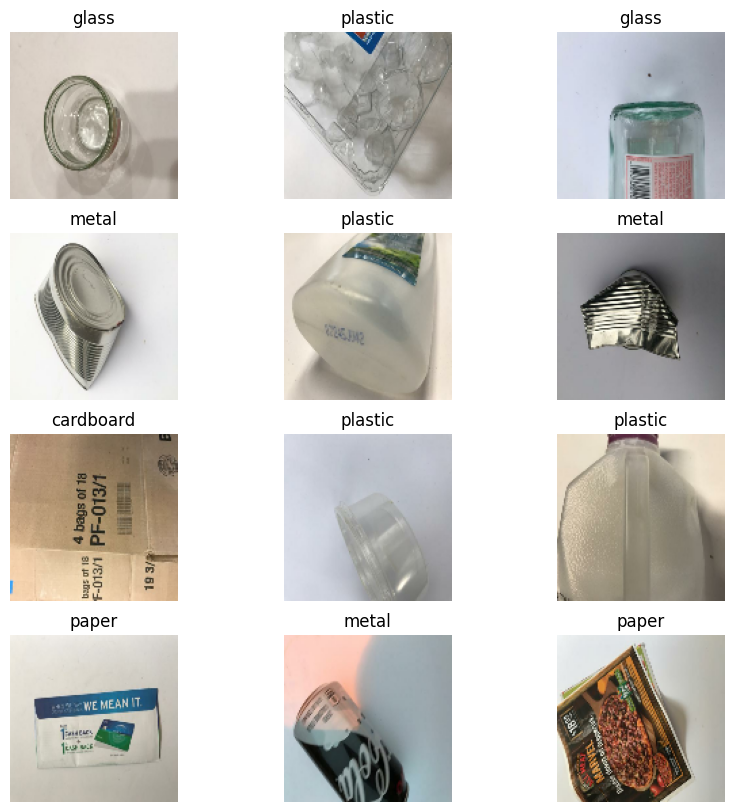

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")